In [10]:
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import numpy as np
import pandas as pd

import eq

## Loading the catalog

In [11]:
print(eq.data.default_catalogs_dir)

/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data


Note that this step can take a long time the first time it is run.

In [12]:
catalog = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=20000,
    radius_kilometers = 200,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,
)

Loading existing catalog from /home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data/ANSS_MultiCatalog.


### Train / val / test split

To compare different models, by default we split the full dataset of event sequences into 3 components:
- `train`: sequences used for training the models, includes events between `1990-01-01` and `2010-01-01`.
- `val`: used for early stopping and hyperparameter selection, includes events between `2010-01-01` and `2015-01-01`.
- `test`: used for final evaluation, includes events between `2015-01-01` and `2020-01-01`.

So now the train, val and test sequences are stored in `catalog.train`, `catalog.val` and `catalog.test`, respectively.

Note that there are multiple event sequences stored in `catalog.train`, `catalog.val` and `catalog.test`.

In [13]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [16],
  arrival_times: [15],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [15],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [110],
  arrival_times: [109],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [109],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [190],
  arrival_times: [189],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [189],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


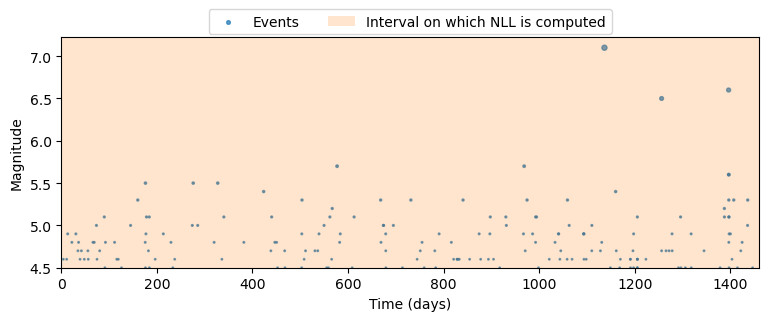

In [14]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True);

## Training the model

We will train the model using the high-level API provided by `pytorch_lightning`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [15]:
dl_train = catalog.train.get_dataloader(batch_size=min(500,len(catalog.train)), shuffle=True)
dl_val = catalog.val.get_dataloader(batch_size=min(500,len(catalog.val)))
dl_test = catalog.test.get_dataloader(batch_size=min(500,len(catalog.test)))

In [16]:
T = catalog.train[0].t_end
N = np.mean([len(seq) for seq in catalog.train])
mag_mean = np.mean([catalog.train[0].mag.mean().item() for seq in catalog.train])
tau_mean = T/N

model = eq.models.RecurrentTPP(
    tau_mean = tau_mean,
    learning_rate=1e-3,
)

`pytorch_lightning.Trainer` takes care of training the model, early stopping and saving the best weights.

In [17]:
# ModelCheckpoints saves the model with the best validation loss
checkpoint = pl_callbacks.ModelCheckpoint(monitor="total_val_loss")

# EarlyStopping stops training if the validation loss doesn't improve by more than 1e-3 for 20 epochs
early_stopping = pl_callbacks.EarlyStopping(monitor="total_val_loss", patience=10, min_delta=1e-5)

# RichProgressBar adds a nice and more functional progress bar
progress_bar = pl_callbacks.RichProgressBar()

# Trainer set up training and validation loops with previous specs
trainer = pl.Trainer(
    devices=1,
    max_epochs=1000, 
    callbacks=[checkpoint, early_stopping, progress_bar],
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, dl_train, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ hypernet_time │ Linear  │  3.2 K │
│ 1 │ hypernet_mag  │ Linear  │     33 │
│ 2 │ rnn           │ GRU     │  3.5 K │
│ 3 │ dropout       │ Dropout │      0 │
└───┴───────────────┴─────────┴────────┘

Trainable params: 6.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 K                                                                                                
Total estimated model params size (MB): 0

Output()

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.18 GiB (GPU 0; 14.62 GiB total capacity; 321.25 MiB already allocated; 447.44 MiB free; 328.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluation

<Axes: xlabel='epoch', ylabel='val_loss'>

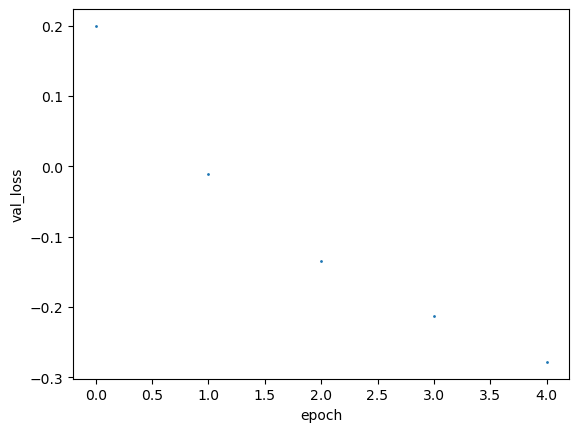

In [ ]:
metrics = pd.read_csv('/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/notebooks/lightning_logs/version_11/metrics.csv')
metrics.plot.scatter(x='epoch',y='val_loss',s=1)

Load the model with the best validation loss

In [ ]:
checkpoint.best_model_path

NameError: name 'checkpoint' is not defined

In [ ]:
model.load_from_checkpoint(checkpoint.best_model_path)

NameError: name 'model' is not defined

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

In [ ]:
trainer.test(model, dl_test)

NameError: name 'trainer' is not defined

In [ ]:
trainer.test(model, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.5846961140632629
     total_test_loss        -0.5846961140632629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.5846961140632629, 'total_test_loss': -0.5846961140632629}]

In [ ]:
for batch in dl_val: # batch size set to 1
#     train the model 
    
#     get the validation nll
    
# average all the nlls


    